# Jax Car Rental
From Example 4.2 in [Sutton & Barto](http://incompleteideas.net/book/the-book.html)

In [1]:
from jax import jit, vmap, partial, make_jaxpr
import jax.numpy as np
from jax.scipy.stats import poisson

In [2]:
def cartesian(*arrays):
  arrays = np.meshgrid(*arrays, indexing='ij')
  arrays = [a.ravel() for a in arrays]
  return arrays

In [3]:
max_transfers = 5
max_cars = 20
max_rental_returns = 11
rental_reward = 10
transfer_reward = -2
l1_rental_rate = 3
l1_return_rate = 3
l2_rental_rate = 4
l2_return_rate = 2
discount_rate = .9

In [4]:
def rent_and_return(count, rentals, returns):
  rentals = np.minimum(count, rentals)
  count -= rentals
  count += returns
  count = np.minimum(count, max_cars)
  return count, rentals

In [5]:
def simulate(
    transfer,
    l1_count,
    l2_count,
    l1_rentals,
    l1_returns,
    l2_rentals,
    l2_returns):

  clipped_transfer = np.clip(transfer, -l2_count, l1_count)
  l1_count -= clipped_transfer
  l2_count += clipped_transfer
  l1_count = np.minimum(l1_count, max_cars)
  l2_count = np.minimum(l2_count, max_cars)
  
  probabilities = poisson.pmf(
      np.array([l1_rentals, l1_returns, l2_rentals, l2_returns]),
      np.array([l1_rental_rate, l1_return_rate, l2_rental_rate, l2_return_rate]),
  )
  probability = np.product(probabilities)

  l1_count, l1_rentals = rent_and_return(l1_count, l1_rentals, l1_returns)
  l2_count, l2_rentals = rent_and_return(l2_count, l2_rentals, l2_returns)
  rentals = l1_rentals + l2_rentals

  reward = np.abs(transfer) * transfer_reward + rentals * rental_reward

  return (probability, reward, l1_count, l2_count)

In [6]:
state_count = (max_cars + 1) ** 2

def state_to_cars(state):
  return np.divmod(state, (max_cars + 1))

def cars_to_state(l1_count, l2_count):
  return l1_count * (max_cars + 1) + l2_count

In [7]:
action_count = max_transfers * 2 + 1

def action_to_transfer(action):
  return action - max_transfers

def transfer_to_action(transfer):
  return transfer + max_transfers

In [8]:
def transition(state, action):
  l1_count, l2_count = state_to_cars(state)
  transfer = action_to_transfer(action)
  rental_return_args = cartesian(
    np.arange(max_rental_returns + 1),
    np.arange(max_rental_returns + 1),
    np.arange(max_rental_returns + 1),
    np.arange(max_rental_returns + 1))
  batch_simulate = vmap(simulate, in_axes=(None, None, None, 0, 0, 0, 0))
  probabilities, rewards, next_l1_counts, next_l2_counts = batch_simulate(
      transfer,
      l1_count,
      l2_count,
      *rental_return_args)
  next_states = cars_to_state(next_l1_counts, next_l2_counts)
  return probabilities, rewards, next_states

In [9]:
def expected_value(state, action, values):
  probablities, rewards, next_states = transition(state, action)
  return np.sum(probablities * (rewards + discount_rate * values[next_states]))

In [10]:
@jit
def evaluate_policy(values, policy):
  batch_expected_value = vmap(expected_value, in_axes=(0, 0, None))
  states = np.arange(state_count)
  return batch_expected_value(states, policy, values)

In [11]:
@jit
def improve_policy(values, policy):
  @vmap
  def next_policy(state):
    batch_expected_value = vmap(expected_value, in_axes=(None, 0, None))
    actions = np.arange(action_count)
    return np.argmax(batch_expected_value(state, actions, values))
  states = np.arange(state_count)
  return next_policy(states)

In [18]:
values = np.zeros(state_count)
policy = np.zeros(state_count, dtype=np.int32)
delta_policy_threshold = 0
delta_values_threshold = 1e-3
delta_policy = np.inf
while delta_policy > delta_policy_threshold:
    delta_values = np.inf
    while delta_values > delta_values_threshold:
        new_values = evaluate_policy(values, policy)
        delta_values = np.max(np.abs(values - new_values))
        values = new_values
    new_policy = improve_policy(values, policy)
    delta_policy = np.sum(policy != new_policy)
    policy = new_policy

In [19]:
import seaborn as sns

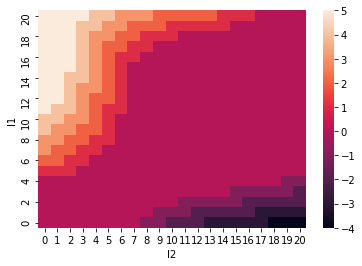

In [21]:
transfers = action_to_transfer(policy.reshape((max_cars + 1, max_cars + 1)))
ax = sns.heatmap(transfers)
ax.set(xlabel='l2', ylabel='l1')
ax.invert_yaxis()

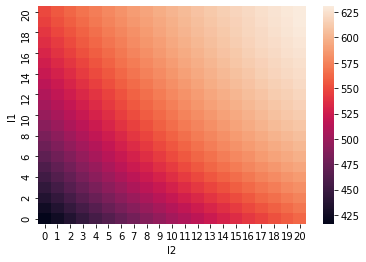

In [22]:
ax = sns.heatmap(values.reshape((max_cars + 1, max_cars + 1)))
ax.set(xlabel='l2', ylabel='l1')
ax.invert_yaxis()